In [28]:

import pandas as pd
import numpy as np
import pickle
import math

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

import scipy.fftpack as fftpack
from scipy.stats import binned_statistic

import argparse
import glob
from datetime import datetime

import F21DataLoader as dl


In [18]:
import numpy as np

arr = np.array([1,2,3,4,5,6,7,8,9,10])
arr = arr[np.random.randint(len(arr), size=5)]
print(arr)

[5 6 5 6 2]


y_pred: [[ 0.82 -0.25]
 [ 0.82  0.3 ]
 [ 0.7  -1.3 ]
 [ 0.5  -0.65]]
y_test: [[ 0.8  0. ]
 [ 0.8  0. ]
 [ 0.6 -1. ]
 [ 0.6 -1. ]]
R2 Score: [0.48000000000000076, 0.635]
rmse_comb : (4,)
[0.07 0.08 0.16 0.17]
Describing test data with rmse:        actual_xHI  actual_logfX  pred_xHI  pred_logfX  rmse_xHI  rmse_logfx  \
count     4.00000       4.00000  4.000000    4.000000  4.000000    4.000000   
mean      0.70000      -0.50000  0.710000   -0.475000  0.060000    0.300000   
std       0.11547       0.57735  0.150997    0.673919  0.046188    0.040825   
min       0.60000      -1.00000  0.500000   -1.300000  0.020000    0.250000   
25%       0.60000      -1.00000  0.650000   -0.812500  0.020000    0.287500   
50%       0.70000      -0.50000  0.760000   -0.450000  0.060000    0.300000   
75%       0.80000       0.00000  0.820000   -0.112500  0.100000    0.312500   
max       0.80000       0.00000  0.820000    0.300000  0.100000    0.350000   

           rmse  
count  4.000000  
mean   0.120

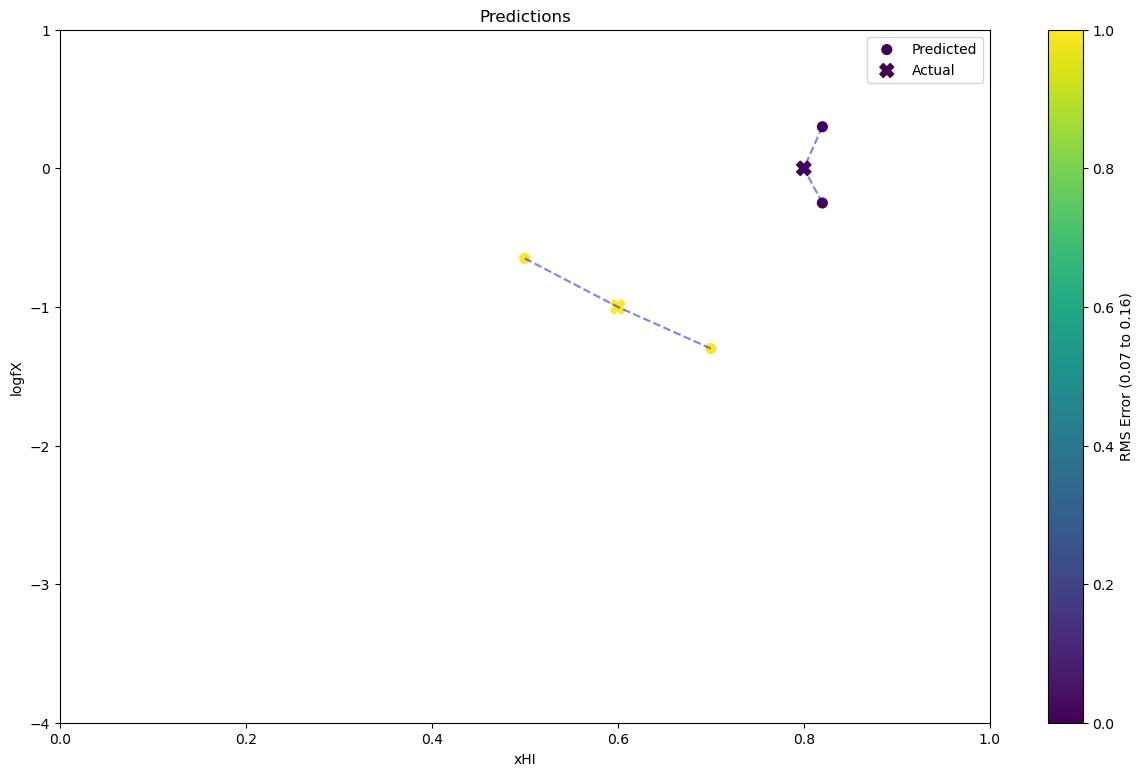

In [44]:
def summarize_test(y_pred, y_test):
    print(f"y_pred: {y_pred}")
    print(f"y_test: {y_test}")
    # Calculate R2 scores
    r2 = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(2)]
    print("R2 Score: " + str(r2))

    # Calculate rmse scores
    rmse = np.sqrt((y_test - y_pred) ** 2)
    rmse_comb = rmse[:,0]+rmse[:,1]/5 # Weighted as per the range of params
    print(f"rmse_comb : {rmse_comb.shape}\n{rmse_comb[:10]}")
    df_y = pd.DataFrame()
    df_y = df_y.assign(actual_xHI=y_test[:,0])
    df_y = df_y.assign(actual_logfX=y_test[:,1])
    df_y = df_y.assign(pred_xHI=y_pred[:,0])
    df_y = df_y.assign(pred_logfX=y_pred[:,1])
    df_y = df_y.assign(rmse_xHI=rmse[:,0])
    df_y = df_y.assign(rmse_logfx=rmse[:,1])
    df_y = df_y.assign(rmse=rmse_comb)
    print(f"Describing test data with rmse: {df_y.describe()}")

    df_y_agg = df_y.groupby(["actual_xHI", "actual_logfX"])['rmse'].mean()
    df_y_agg.rename('agg_rmse', inplace=True)
    df_y = df_y.merge(df_y_agg, on=['actual_xHI', 'actual_logfX'], validate='many_to_one')
    print(f"Describing data with rmse: \n{df_y.describe()}\n{df_y.head()}")

    rmse_summary = df_y.groupby(["actual_xHI", "actual_logfX"]).agg({'agg_rmse':'mean','rmse_xHI':'mean','rmse_logfx': 'mean'})
    print(f"rmse Summary: \n{rmse_summary}")

    cmap = plt.get_cmap('viridis')
    rmse = df_y['agg_rmse']
    rmse_min = rmse.min()
    rmse_max = rmse.max()
    norm = plt.Normalize(rmse.min(), rmse.max())
    colors = cmap(norm(rmse))    

    plt.rcParams['figure.figsize'] = [15, 9]
    plt.scatter(df_y['pred_xHI'], df_y['pred_logfX'], marker="o", s=49, label='Predicted', c=colors)
    plt.plot([df_y['pred_xHI'], df_y['actual_xHI']], [df_y['pred_logfX'], df_y['actual_logfX']], 'b--', alpha=0.5)
    plt.scatter(df_y['actual_xHI'], df_y['actual_logfX'], marker="X", s=100, label='Actual', c=colors)
    plt.xlim(0, 1)
    plt.ylim(-4, 1)
    plt.xlabel('xHI')
    plt.ylabel('logfX')
    plt.title('Predictions')
    plt.legend()
    plt.colorbar(label=f'RMS Error ({rmse_min:.2f} to {rmse_max:.2f})')
    plt.show()

summarize_test(np.array([
    [0.82, -0.25], 
    [0.82, 0.3], 
    [0.7, -1.3], 
    [0.5, -0.65]]), 
    np.array([
        [0.8, 0.0], 
        [0.8, 0.0], 
        [0.6, -1.0], 
        [0.6, -1.0]]))

In [30]:
with open('alldatafiles.txt', 'r') as file:
    all_files = file.readlines()
    # Remove any whitespace/newlines
    all_files = [f.strip() for f in all_files]

# Split into train and test sets
train_files, test_files = train_test_split(all_files, test_size=16, random_state=42)
print('\n'.join(test_files))


F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.80_xHI0.35_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.80_xHI0.11_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.60_xHI0.70_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.60_xHI0.14_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.60_xHI0.44_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX1.00_xHI0.25_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.60_xHI1.00_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.80_xHI0.79_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.60_xHI0.35_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.20_xHI0.35_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.20_xHI0.80_uGMRT_8kHz_t50h_Smin64.2m

In [2]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras.saving import load_model
from keras.losses import huber
import numpy as np

def create_cnn_model(input_shape):
    """Create a CNN model for regression"""
    model = models.Sequential([
        layers.Reshape((*input_shape, 1), input_shape=input_shape),
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.1),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.2),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(2)  # Output layer with 2 neurons for xHI and logfX
    ])

    # Compile the model  
    model.compile(loss=huber, optimizer='adam', metrics=['accuracy'])

    # Summary of the model
    model.summary()
    print("######## completed model setup #########")

    return model

print("Starting training")

X_train_subset = np.array([[1,2,3,4,5,6,7,8],[2,3,4,5,6,7,8,9]])
y_train_subset = np.array([[2, 3], [3,4]])
print(f"Training dataset: X:{X_train_subset.shape} y:{y_train_subset.shape}")

# Create and compile the model
input_shape = (X_train_subset.shape[1],)
model = create_cnn_model(input_shape)
        
        # Early stopping callback
early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
)
    
print(f"{X_train_subset.shape}")
X_train_subset = X_train_subset.reshape(len(X_train_subset), X_train_subset.shape[1], 1)
print(f"Fitting data: {X_train_subset.shape}")
model.fit(
            X_train_subset, y_train_subset,
            epochs=10,
            batch_size=32,
            validation_split=0.2,
            #callbacks=[early_stopping],
            verbose=1
)

        # Test the model
print("Testing prediction")
#y_pred = model.predict(X_test)

Starting training
Training dataset: X:(2, 8) y:(2, 2)


c:\Users\Sanaya\anaconda3\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 8, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 8, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,834 (222.01 KB)

 Trainable params: 56,386 (220.26 KB)

 Non-trainable params: 448 (1.75 KB)

######## completed model setup #########
(2, 8)
Fitting data: (2, 8, 1)
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.0000e+00 - loss: 1.9335 - val_accuracy: 0.0000e+00 - val_loss: 2.7481
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.0000e+00 - loss: 1.8024 - val_accuracy: 0.0000e+00 - val_loss: 2.6779
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0000e+00 - loss: 1.3700 - val_accuracy: 0.0000e+00 - val_loss: 2.6024
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0000e+00 - loss: 1.1645 - val_accuracy: 0.0000e+00 - val_loss: 2.5170
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0000e+00 - loss: 0.6085 - val_accuracy: 0.0000e+00 - val_loss: 2.4282
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0000e+00 - loss: 1.1150 - val_accuracy: 0.0000e+00 - val_loss: 2.3335
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.0000e+00 - loss: 0.5300 - val_accuracy: 0.0000e+00 - val_loss: 2.2367